In [ ]:
import urllib
import bs4
import pandas
import re
import pandas as pd
from urllib import request
import requests
import tempfile
import zipfile
import geopandas as gpd

In [ ]:
! pip install geopandas
! apt install libspatialindex-dev
! pip install "rtree>=0.8,<0.9"

     |████████████████████████████████| 972kB 5.8MB/s 
     |████████████████████████████████| 6.5MB 44.2MB/s 
     |████████████████████████████████| 14.8MB 267kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (735 kB/s)
Selecting previously un

In [ ]:
! apt install libspatialindex-dev
! pip install "rtree>=0.8,<0.9"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
import geopandas as gpd

In [ ]:
# getting all the links of the pages that dispaly all the restaurants (1,2,3 ..... 169 page) by just looking at the way used to create the links
links=["https://guide.michelin.com/fr/fr/restaurants"]+["https://guide.michelin.com/fr/fr/restaurants/page/"+str(i) for i in range (2,170)]

In [ ]:
#requesting all the needed pages to be scraped later
requested_elements=[request.urlopen(url).read() for url in links]

In [ ]:
pages = [bs4.BeautifulSoup(request, "lxml") for request in requested_elements]

In [ ]:
# finding all the restaurents in one page
restaurents_cards=[page.find_all("div",{"class": "col-md-6 col-lg-6 col-xl-3"}) for page in pages]
restaurents=[]
for i in restaurents_cards:
  restaurents+=i


In [ ]:
# we have 3368 restaurents
len(restaurents)

3368

In [ ]:
#find all the restaurent pages
restaurents_links=[ restaurent.find("a",{"class":"link"}).get_attribute_list("href")[0] for restaurent in restaurents ] 

In [ ]:
restaurents_links=['https://guide.michelin.com/'+ link for link in restaurents_links]
restaurents_links

['https://guide.michelin.com//fr/fr/provence-alpes-cote-dazur/nice/restaurant/la-rotonde-1184636',
 'https://guide.michelin.com//fr/fr/monaco-region/monaco/restaurant/la-montgolfiere-henri-geraci',
 'https://guide.michelin.com//fr/fr/monaco-region/monte-carlo/restaurant/maya-bay',
 'https://guide.michelin.com//fr/fr/monaco-region/fontvieille/restaurant/beefbar208467',
 'https://guide.michelin.com//fr/fr/monaco-region/monte-carlo/restaurant/le-louis-xv-alain-ducasse-a-l-hotel-de-paris',
 'https://guide.michelin.com//fr/fr/monaco-region/monte-carlo/restaurant/la-maree',
 'https://guide.michelin.com//fr/fr/monaco-region/monte-carlo/restaurant/vistamar',
 'https://guide.michelin.com//fr/fr/monaco-region/monaco/restaurant/omer',
 'https://guide.michelin.com//fr/fr/monaco-region/monte-carlo/restaurant/le-blue-bay',
 'https://guide.michelin.com//fr/fr/monaco-region/monte-carlo/restaurant/loga',
 'https://guide.michelin.com//fr/fr/monaco-region/monte-carlo/restaurant/yoshi',
 'https://guide.mi

In [ ]:
restaurents_links[402]

'https://guide.michelin.com//fr/fr/ile-de-france/paris/restaurant/lili'

In [ ]:

restaurent= bs4.BeautifulSoup(request.urlopen(restaurents_links[18]).read(), "lxml") 


In [ ]:
df=pd.DataFrame(columns=["name","address","price","speciality","review","mark","votes","services","phone number","website","latitude","longitude"])

In [ ]:
# function to treat the data and get the needed fields
def treat_data(restaurent): 
  inf={}
  inf['name']=restaurent.find("h2",{'class':'restaurant-details__heading--title'}).get_text()
  restaurent_details=restaurent.find("ul",{'class':'restaurant-details__heading--list'}).find_all('li')
  if (restaurent_details[0].get_attribute_list("class")[0]=="restaurant-details__heading-experience-title"):
    restaurent_details.pop(0)
  inf['address']=restaurent_details[0].get_text()
  if (len(restaurent_details)==3):
    #getting the note and the number of voters
    note_avis= re.sub("\s+"," ",restaurent_details[1].get_text().replace("\n",'')).split("•")
    inf["mark"] = re.findall("\d / \d | \d,\d / \d ",note_avis[0])
    inf["votes"] = note_avis[1]
    price_spec=re.sub("\s+"," ",restaurent_details[2].get_text().replace("\n",'')).split("•")
    # getting the price and the speciality of the restaurant
    if len(re.findall("EUR",price_spec[0]))!=0 :
      if (len(price_spec)==2):
        inf["price"]=price_spec[0]
        inf["speciality"]=price_spec[1].split(',')
      elif (len(price_spec)==1):
        inf["price"]=price_spec[0].split(',')
    else:
      if (len(price_spec)==1):
        inf["speciality"]=price_spec[0]
  elif (len(restaurent_details)==2):
    price_spec=re.sub("\s+"," ",restaurent_details[1].get_text().replace("\n",'')).split("•")
    # getting the price and the speciality of the restaurant
    if len(re.findall("EUR",price_spec[0]))!=0 :
      if (len(price_spec)==2):
        inf["price"]=price_spec[0]
        inf["speciality"]=price_spec[1].split(',')
      elif (len(price_spec)==1):
        inf["price"]=price_spec[0].split(',')
    else:
      if (len(price_spec)==1):
        inf["speciality"]=price_spec[0]
  #getting the michelin review
  inf["review"]=restaurent.find("div",{'class':'js-show-description-text'}).get_text().replace("\n",'')
  #getting thre restaurent services
  restautrent_service= [rest.get_text() for rest in restaurent.find("ul",{"class":"row restaurant-details__services--list js-show-more"}).find_all('div')]
  restautrent_service= [" ".join(re.sub("\s+"," ",rest.replace("\n","")).split(" ")[1:]) for rest in restautrent_service ]
  inf["services"]=restautrent_service
  #getting the restaurent information
  restaurentInf=restaurent.find_all('div',{'class':'collapse__block-item'})
  if (len(restaurentInf)==2):
    inf["phone number"]=restaurentInf[0].get_text().replace('\n','')
    inf["website"]=restaurentInf[1].get_text().replace('\n','')
  elif (len(restaurentInf)==1):
    inf["phone number"]=restaurentInf[0].get_text().replace('\n','')
  #getting the coordination of restaurent from the query link used by the google map api
  restaurentLink=restaurent.find('div',{'class':'google-map__static'}).find("iframe",{'frameborder':'0'}).get_attribute_list("src")[0]
  inf["latitude"]=re.findall('=\d+.\d+|=-\d+.\d+',restaurentLink)[0][1:]
  inf["longitude"]=re.findall(',\d+.\d+|,-\d+.\d+',restaurentLink)[0][1:]
  return inf


In [ ]:
#collecting all the restaurent_data
for i in range(len(restaurents_links)):
  print(i)
  restaurent=bs4.BeautifulSoup(request.urlopen(restaurents_links[i]))
  inf=treat_data(restaurent)
  df=df.append(inf,ignore_index=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:

print(restaurents_links[3066])
restaurent=bs4.BeautifulSoup(request.urlopen(restaurents_links[3066]))
restaurent_details=restaurent.find("ul",{'class':'restaurant-details__heading--list'}).find_all('li')
if (restaurent_details[0].get_attribute_list("class")[0]=="restaurant-details__heading-experience-title"):
    print("hi")
note_avis= re.sub("\s+"," ",restaurent_details[1].get_text().replace("\n",'')).split("•")
print(note_avis)
note = re.findall("\d / \d | \d,\d / \d ",note_avis[0])

https://guide.michelin.com//fr/fr/bourgogne-franche-comte/meursault/restaurant/le-soufflot
[' 32 - 61 EUR ', ' Cuisine moderne, Cuisine actuelle ']


In [ ]:
  restaurent=bs4.BeautifulSoup(request.urlopen(restaurents_links[3066]))
  inf={}
  inf['name']=restaurent.find("h2",{'class':'restaurant-details__heading--title'}).get_text()
  restaurent_details=restaurent.find("ul",{'class':'restaurant-details__heading--list'}).find_all('li')
  if (restaurent_details[0].get_attribute_list("class")[0]=="restaurant-details__heading-experience-title"):
    print("hi")
    restaurent_details.pop(0)
  inf['address']=restaurent_details[0].get_text()
  if (len(restaurent_details)==3):
    #getting the note and the number of voters
    note_avis= re.sub("\s+"," ",restaurent_details[1].get_text().replace("\n",'')).split("•")
    inf["mark"] = re.findall("\d / \d | \d,\d / \d ",note_avis[0])
    inf["votes"] = note_avis[1]
    price_spec=re.sub("\s+"," ",restaurent_details[2].get_text().replace("\n",'')).split("•")
    # getting the price and the speciality of the restaurant
    if len(re.findall("EUR",price_spec[0]))!=0 :
      if (len(price_spec)==2):
        inf["price"]=price_spec[0]
        inf["speciality"]=price_spec[1].split(',')
      elif (len(price_spec)==1):
        inf["price"]=price_spec[0].split(',')
    else:
      if (len(price_spec)==1):
        inf["speciality"]=price_spec[0]
  elif (len(restaurent_details)==2):
    price_spec=re.sub("\s+"," ",restaurent_details[1].get_text().replace("\n",'')).split("•")
    # getting the price and the speciality of the restaurant
    if len(re.findall("EUR",price_spec[0]))!=0 :
      if (len(price_spec)==2):
        inf["price"]=price_spec[0]
        inf["speciality"]=price_spec[1].split(',')
      elif (len(price_spec)==1):
        inf["price"]=price_spec[0].split(',')
    else:
      if (len(price_spec)==1):
        inf["speciality"]=price_spec[0]
  #getting the michelin review
  inf["review"]=restaurent.find("div",{'class':'js-show-description-text'}).get_text().replace("\n",'')
  #getting thre restaurent services
  restautrent_service= [rest.get_text() for rest in restaurent.find("ul",{"class":"row restaurant-details__services--list js-show-more"}).find_all('div')]
  restautrent_service= [" ".join(re.sub("\s+"," ",rest.replace("\n","")).split(" ")[1:]) for rest in restautrent_service ]
  inf["services"]=restautrent_service
  #getting the restaurent information
  restaurentInf=restaurent.find_all('div',{'class':'collapse__block-item'})
  if (len(restaurentInf)==2):
    inf["phone number"]=restaurentInf[0].get_text().replace('\n','')
    inf["website"]=restaurentInf[1].get_text().replace('\n','')
  elif (len(restaurentInf)==1):
    inf["phone number"]=restaurentInf[0].get_text().replace('\n','')
  #getting the coordination of restaurent from the query link used by the google map api
  restaurentLink=restaurent.find('div',{'class':'google-map__static'}).find("iframe",{'frameborder':'0'}).get_attribute_list("src")[0]
  inf["latitude"]=re.findall('=\d+.\d+|=-\d+.\d+',restaurentLink)[0][1:]
  inf["longitude"]=re.findall(',\d+.\d+|,-\d+.\d+',restaurentLink)[0][1:]
  inf

{'address': '8 route Nationale 74, Meursault, 21190, France',
 'latitude': '46.9740789',
 'longitude': '4.7846431',
 'name': 'Le Soufflot',
 'price': ' 32 - 61 EUR ',
 'review': "Le jeune chef Jérémy Pèze réalise une cuisine gourmande, fine et délicate dans ce restaurant situé à l'intérieur d'une ancienne maison de vigneron. Sans oublier la remarquable carte de vins, et le bon rapport qualité/prix, à midi (menu unique le soir).",
 'services': ['Restaurant non fumeur ',
  'Parking ',
  'Air conditionné ',
  'Cartes de crédit acceptées ',
  'Mastercard ',
  'Carte de crédit Visa ',
  'Carte des vins particulièrement intéressante '],
 'speciality': [' Cuisine moderne', ' Cuisine actuelle ']}

In [ ]:
df

,name,address,price,speciality,review,mark,votes,services,phone number,website,latitude,longitude,Michelin Stars
0,La Rotonde,"37 promenade des Anglais, Nice, 06000, France",49 - 89 EUR,Cuisine méditerranéenne,La brasserie – en forme de rotonde – du palace...,NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",+33 4 93 16 64 11,www.hotel-negresco-nice.com,43.694300,7.257998,1
1,La Montgolfière-Henri Geraci,"16 rue Basse, Monaco, 98000, France",31 - 70 EUR,Cuisine moderne,"Dans une ruelle piétonne du rocher, à deux pas...",NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",NaN,NaN,43.731030,7.422599,0
2,Maya Bay,"24 avenue Princesse-Grace, Monte-Carlo, 98000,...",18 - 180 EUR,"Cuisine thaïlandaise, Cuisine japonaise","Dans un même lieu, un restaurant japonais et u...",NaN,NaN,"['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,43.748800,7.435480,0
3,Beefbar,"42 quai Jean-Charles-Rey, port de Fontvieille,...",45 - 130 EUR,"Spécialités de Viandes, Spécialités de Grilla...",Sur les quais du port de plaisance de Fontviei...,NaN,NaN,"['Vue ', 'Restaurant non fumeur ', 'Air condit...",+377 97 77 09 29,www.monaco.beefbar.com,43.727840,7.421580,0
4,Le Louis XV - Alain Ducasse à l'Hôtel de Paris,"Place du Casino, Monte-Carlo, 98000, France",180 - 380 EUR,Cuisine méditerranéenne,"Difficile de présenter le Louis XV, sans évoqu...",NaN,NaN,"['Accès handicapés ', 'Voiturier ', 'Restauran...",NaN,NaN,43.739201,7.427330,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,Monsieur P,"8 place des Célestins, Lyon, 69002, France",32 - 98 EUR,Cuisine moderne,"Nouvelle adresse pour Monsieur P, qui a eu l'a...",NaN,NaN,"['Restaurant non fumeur ', 'Salon particulier ...",NaN,NaN,45.759541,4.831701,0
3364,Le Bastion,"50 boulevard de la Promenade, Lagrasse, 11220,...",21 - 60 EUR,Cuisine moderne,Cet ancien bastion médiéval du huitième siècle...,NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",NaN,NaN,43.089123,2.619698,0
3365,Quatre Saisons,"10 rue Jean-Baptiste-Champeil, Aurillac, 15000...",34 - 75 EUR,Cuisine moderne,Sincère et bien tournée : telle est la cuisine...,NaN,NaN,"['Restaurant non fumeur ', 'Air conditionné ',...",NaN,NaN,44.929860,2.446885,0
3366,Le Relais de Beaufort,"RN 2, Beaufort, 59330, France",NaN,NaN,Une auberge contemporaine ornée de sculptures ...,NaN,NaN,"['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,50.210193,3.948989,0


In [ ]:
df= pd.read_csv("/FrenchRestaurentData_V2.csv")

In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'name', 'address', 'price', 'speciality',
       'review', 'services', 'phone number', 'website', 'latitude',
       'longitude', 'Michelin Stars', 'nb_service', 'pays', 'code', 'ville',
       'specialite_1', 'specialite_2'],
      dtype='object')

In [ ]:
#adding the number of michelin stars to our data frame
links=["https://guide.michelin.com/fr/fr/restaurants/3-etoiles-michelin","https://guide.michelin.com/fr/fr/restaurants/3-etoiles-michelin/page/2"]
list_three_stars=[]
for link in links:
  page=bs4.BeautifulSoup(request.urlopen(link))
  list=page.find_all('div',{'class':'col-md-6 col-lg-6 col-xl-3'})
  list=[re.sub("\s+"," ", resto.find("h5").get_text().strip("\n")).strip() for resto in list]
  list_three_stars+=list
print(len(list_three_stars))

29




                Le Louis XV - Alain Ducasse à l'Hôtel de Paris
            



In [ ]:
list_three_stars

["Le Louis XV - Alain Ducasse à l'Hôtel de Paris",
 'Assiette Champenoise',
 "Les Prés d'Eugénie - Michel Guérard",
 'Georges Blanc',
 "La Vague d'Or - Cheval Blanc St-Tropez",
 'Mirazur',
 'René et Maxime Meilleur',
 'Alléno Paris au Pavillon Ledoyen',
 'Le 1947',
 'Alain Ducasse au Plaza Athénée',
 'Pic',
 'Troisgros - Le Bois sans Feuilles',
 'Pierre Gagnaire',
 'Le Pré Catelan',
 "L'Ambroisie",
 'Épicure',
 'Christophe Bacquié',
 'Maison Lameloise',
 'Flocons de Sel',
 'Le Cinq',
 'Guy Savoy',
 'Auberge du Vieux Puits',
 'Arpège',
 'Kei',
 "L'Oustau de Baumanière",
 'Christopher Coutanceau',
 'Le Petit Nice',
 'Régis et Jacques Marcon',
 'Le Clos des Sens']

In [ ]:
links_2_stars=["https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin","https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin/page/2","https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin/page/3","https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin/page/4","https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin/page/5"]
list_two_stars=[]
for link in links_2_stars:
  page=bs4.BeautifulSoup(request.urlopen(link))
  list=page.find_all('h5',{'class':'card__menu-content--title last pl-text pl-big'})
  list=[re.sub("\s+"," ", title.get_text().strip('\n')).strip() for title in list]
  list_two_stars+=list

In [ ]:
list_two_stars

['Jean Sulpice',
 'Le Montgomerie',
 'Serge Vieira',
 'Racine',
 'Sarkara',
 'Au 14 Février',
 'La Maison des Bois - Marc Veyrat',
 'Les Hauts de Loire',
 'La Table de Pavie',
 'Le Kintessence',
 'La Scène',
 'AM par Alexandre Mazzia',
 'SaQuaNa',
 "Le Pressoir d'Argent - Gordon Ramsay",
 'La Marine',
 "L'Atelier de Joël Robuchon - St-Germain",
 'Meurin',
 'Le Puits St-Jacques',
 'Les Cèdres',
 'Le Grand Véfour',
 'Takao Takano',
 'Le Chabichou by Stéphane Buron',
 "JY'S",
 'La Grenouillère',
 'La Fourchette des Ducs',
 'Py-r',
 'Le Gabriel',
 "La Palme d'Or",
 'Le Coquillage',
 'La Bastide de Capelongue',
 'Les Maisons Rabanel',
 'Le Skiff Club',
 'Michel Sarran',
 'Bras',
 'La Voile',
 'La Grande Maison de Bernard Magrez']

In [ ]:
link_one_star=["https://guide.michelin.com/fr/fr/restaurants/1-etoile-michelin"]+["https://guide.michelin.com/fr/fr/restaurants/1-etoile-michelin/page/"+str(i) for i in range(2,26)]

In [ ]:
list_one_star=[]
for link in link_one_star:
  page=bs4.BeautifulSoup(request.urlopen(link))
  list=page.find_all('h5',{'class':'card__menu-content--title last pl-text pl-big'})
  list=[re.sub("\s+"," ", title.get_text().strip('\n')).strip() for title in list]
  list_one_star+=list

In [ ]:
list_one_star

['Yoshi',
 'Le Georges',
 'Hostellerie de Levernois',
 "L'Auberge de Bagatelle",
 'Côté Jardin',
 'Cyril Attrazic',
 'Le Vieux Logis',
 'À Contre Sens',
 'Intuition',
 'Holen',
 'La Chaumière',
 'Restaurant De Lauzun',
 'Garopapilles',
 "L'Épuisette",
 'Rodolphe',
 'Château de la Treyne',
 'Auberge St-Jean',
 'Umami',
 'G.a. au Manoir de Rétival',
 'La Meynardie',
 "L'Éveil des Sens",
 'La Table de Chaintré',
 'Äponem - Auberge du Presbytère',
 'Auberge du Cellier',
 "L'Atelier Yssoirien",
 'La Table des Frères Ibarboure',
 'Tomy & Co',
 'Kasbür',
 'Saisons',
 'Pierre',
 'Aida',
 "L'Aspérule",
 'Le Patio',
 'Les Fresques',
 "L'Orchidée",
 "L'Arbre au Soleil",
 "L'Auberge de Montmin",
 "L'Impertinent",
 "Stéphane Tournié - Les Jardins de l'Opéra",
 'Auberge du Dun',
 "L'Or Q'idée",
 "L'Essentiel",
 'Apicius',
 'Côté Cuisine',
 "L'Écrin",
 'Saisons',
 'Baieta',
 'Le Prieuré',
 "L'Amphitryon",
 'Le Bon Accueil',
 'Hedone',
 'La Robe',
 "Les Voiles d'Or",
 "L'Orée de la Forêt",
 "L'Étang d

In [ ]:
values1=df[df['name'].isin(list_one_star)].index
values2=df[df['name'].isin(list_two_stars)].index
values3=df[df['name'].isin(list_three_stars)].index

In [ ]:
#adding the corresponding michelin star to each restaurent using the index
list_michelin_stars=[ 1 if i in values1 else 2 if i in values2 else 3 if i in values3 else 0  for i in range(3368)]

In [ ]:
list_michelin_stars

[1,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [ ]:
#showing the result
df=df.reindex(columns=["name","address","price","speciality","review","mark","votes","services","phone number","website","latitude","longitude"])

In [ ]:
df["Michelin Stars"]=list_michelin_stars

In [9]:
#saving the dataframe
df.to_csv("/FrenchRestaurentData_V2.csv")

NameError: ignored

In [15]:
dataframe=pd.read_csv("/FrenchRestaurentData_V2.csv")

In [16]:
#converting latitude and logitude to a float
dataframe.latitude.apply(float)
dataframe.longitude.apply(float)

0       7.257998
1       7.422599
2       7.435480
3       7.421580
4       7.427330
          ...   
3363    4.831701
3364    2.619698
3365    2.446885
3366    3.948989
3367    5.887947
Name: longitude, Length: 3368, dtype: float64

In [17]:
# creating a geopands dataframe in order to draw the restaurents on the map of france
gpdDf = gpd.GeoDataFrame(dataframe,geometry=gpd.points_from_xy(dataframe.longitude, dataframe.latitude))[["name","address","price","speciality","review","services","phone number","website","Michelin Stars","geometry"]]

In [18]:
gpdDf

,name,address,price,speciality,review,services,phone number,website,Michelin Stars,geometry
0,La Rotonde,"37 promenade des Anglais, Nice, 06000, France",49 - 89 EUR,[' Cuisine méditerranéenne '],La brasserie – en forme de rotonde – du palace...,"['Restaurant non fumeur ', 'Repas en terrasse ...",+33 4 93 16 64 11,www.hotel-negresco-nice.com,1,POINT (7.25800 43.69430)
1,La Montgolfière-Henri Geraci,"16 rue Basse, Monaco, 98000, France",31 - 70 EUR,[' Cuisine moderne '],"Dans une ruelle piétonne du rocher, à deux pas...","['Restaurant non fumeur ', 'Repas en terrasse ...",NaN,NaN,0,POINT (7.42260 43.73103)
2,Maya Bay,"24 avenue Princesse-Grace, Monte-Carlo, 98000,...",18 - 180 EUR,"[' Cuisine thaïlandaise', ' Cuisine japonaise ']","Dans un même lieu, un restaurant japonais et u...","['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,0,POINT (7.43548 43.74880)
3,Beefbar,"42 quai Jean-Charles-Rey, port de Fontvieille,...",45 - 130 EUR,"[' Spécialités de Viandes', ' Spécialités de G...",Sur les quais du port de plaisance de Fontviei...,"['Vue ', 'Restaurant non fumeur ', 'Air condit...",+377 97 77 09 29,www.monaco.beefbar.com,0,POINT (7.42158 43.72784)
4,Le Louis XV - Alain Ducasse à l'Hôtel de Paris,"Place du Casino, Monte-Carlo, 98000, France",180 - 380 EUR,[' Cuisine méditerranéenne '],"Difficile de présenter le Louis XV, sans évoqu...","['Accès handicapés ', 'Voiturier ', 'Restauran...",NaN,NaN,3,POINT (7.42733 43.73920)
...,...,...,...,...,...,...,...,...,...,...
3363,Monsieur P,"8 place des Célestins, Lyon, 69002, France",32 - 98 EUR,[' Cuisine moderne '],"Nouvelle adresse pour Monsieur P, qui a eu l'a...","['Restaurant non fumeur ', 'Salon particulier ...",NaN,NaN,0,POINT (4.83170 45.75954)
3364,Le Bastion,"50 boulevard de la Promenade, Lagrasse, 11220,...",21 - 60 EUR,[' Cuisine moderne '],Cet ancien bastion médiéval du huitième siècle...,"['Restaurant non fumeur ', 'Repas en terrasse ...",NaN,NaN,0,POINT (2.61970 43.08912)
3365,Quatre Saisons,"10 rue Jean-Baptiste-Champeil, Aurillac, 15000...",34 - 75 EUR,[' Cuisine moderne '],Sincère et bien tournée : telle est la cuisine...,"['Restaurant non fumeur ', 'Air conditionné ',...",NaN,NaN,0,POINT (2.44688 44.92986)
3366,Le Relais de Beaufort,"RN 2, Beaufort, 59330, France",37 - 56 EUR,[' Cuisine traditionnelle '],Une auberge contemporaine ornée de sculptures ...,"['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,0,POINT (3.94899 50.21019)


In [19]:
gpdDf[gpdDf["name"]=="Le Petit Nice"]

,name,address,price,speciality,review,services,phone number,website,Michelin Stars,geometry
3065,Le Petit Nice,"Anse de Maldormé, Marseille, 13007, France",130 - 390 EUR,[' Poissons et fruits de mer '],Impossible de dissocier Le Petit Nice de sa vi...,"['Accès handicapés ', 'Vue ', 'Restaurant non ...",NaN,NaN,3,POINT (5.35219 43.28033)


In [20]:
#preparing france map (the code is copied from tp_geopandas)
temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
  with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [21]:
#https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12
download_unzip("https://www.data.gouv.fr/en/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12", temporary_location )

In [22]:
communes_borders = gpd.read_file("../tmp/borders/communes-20190101.json")

In [ ]:
communes_borders

,insee,nom,wikipedia,surf_ha,geometry
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318,"POLYGON ((-60.93595 14.58812, -60.93218 14.585..."
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325,"POLYGON ((-61.12165 14.71928, -61.11852 14.716..."
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374,"POLYGON ((-61.13355 14.74657, -61.13066 14.748..."
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324,"POLYGON ((-61.08459 14.72510, -61.08430 14.722..."
4,97212,Gros-Morne,fr:Gros-Morne,4601,"POLYGON ((-61.08459 14.72510, -61.08061 14.725..."
...,...,...,...,...,...
34977,95219,Ermont,fr:Ermont,416,"POLYGON ((2.24366 48.99420, 2.24912 48.99973, ..."
34978,78172,Conflans-Sainte-Honorine,fr:Conflans-Sainte-Honorine,988,"POLYGON ((2.07187 48.99338, 2.07147 48.99554, ..."
34979,78005,Achères,fr:Achères (Yvelines),972,"POLYGON ((2.04907 48.95682, 2.04918 48.96010, ..."
34980,78358,Maisons-Laffitte,fr:Maisons-Laffitte,693,"POLYGON ((2.17312 48.96406, 2.17813 48.96383, ..."


In [23]:
# getting the first two number of the postal code to elimnate the "outre mer" cities
france_Met=["0"+str(i) if i<10 else str(i) for i in range(1,96)]
france_Met

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95']

In [26]:
# we thought of leaving the "outre-mer" departements ti get a better diplay when plotting the dataframe
communes_borders=communes_borders[communes_borders.insee.str[:2].isin(france_Met)]

In [27]:
restaurantCommuneDf=gpd.sjoin(gpdDf,communes_borders,how="inner",op="within")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [28]:
restaurantCommuneDf

,name,address,price,speciality,review,services,phone number,website,Michelin Stars,geometry,index_right,insee,nom,wikipedia,surf_ha
0,La Rotonde,"37 promenade des Anglais, Nice, 06000, France",49 - 89 EUR,[' Cuisine méditerranéenne '],La brasserie – en forme de rotonde – du palace...,"['Restaurant non fumeur ', 'Repas en terrasse ...",+33 4 93 16 64 11,www.hotel-negresco-nice.com,1,POINT (7.25800 43.69430),29729,06088,Nice,fr:Nice,7400
47,Mon Petit Café,"11 bis rue Grimaldi, Nice, 06000, France",33 - 50 EUR,[' Cuisine moderne '],"Salle chaleureuse et intérieur bleu vénitien, ...","['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,0,POINT (7.26501 43.69887),29729,06088,Nice,fr:Nice,7400
240,Le Chantecler,"37 promenade des Anglais, Nice, 06000, France",125 - 230 EUR,[' Cuisine moderne '],"Sur la mythique Promenade des Anglais, le Negr...","['Accès handicapés ', 'Voiturier ', 'Restauran...",NaN,NaN,0,POINT (7.25802 43.69427),29729,06088,Nice,fr:Nice,7400
446,Le Séjour Café,"11 rue Grimaldi, Nice, 06000, France",32 - 50 EUR,[' Cuisine moderne '],"Des étagères garnies de livres, de bibelots et...","['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,0,POINT (7.26504 43.69880),29729,06088,Nice,fr:Nice,7400
473,L'Aromate,"2 rue Gustave-Deloye, Nice, 06000, France",85 - 105 EUR,[' Cuisine moderne '],"C'est au cœur de Nice, à proximité de la place...","['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,0,POINT (7.26989 43.69922),29729,06088,Nice,fr:Nice,7400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,La Table d'à Côté,"200 allée des Quatre-Vents, Ardon, 45160, France",60 - 103 EUR,"[' Cuisine moderne', ' Cuisine créative ']","Face au golf de Limère, Christophe Hay (La Mai...","['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,0,POINT (1.91242 47.82209),15601,45006,Ardon,fr:Ardon (Loiret),5470
3355,Auberge Batby,"63 Avenue de Galleben, Soustons, 40140, France",18 - 44 EUR,[' Cuisine traditionnelle '],"Un restaurant situé juste au bord du lac, où l...","['Accès handicapés ', 'Avec chambre ', 'Restau...",NaN,NaN,0,POINT (-1.33714 43.75848),27884,40310,Soustons,fr:Soustons,10810
3357,Les Tables de Gaspard,"Rue Principale, Saint-Crépin, 05600, France",36 - 74 EUR,"[' Cuisine moderne', ' Cuisine du marché ']",On passe un excellent moment dans ce restauran...,"['Accès handicapés ', 'Avec chambre ', 'Restau...",NaN,NaN,0,POINT (6.60811 44.70659),26525,05136,Saint-Crépin,fr:Saint-Crépin (Hautes-Alpes),4650
3366,Le Relais de Beaufort,"RN 2, Beaufort, 59330, France",37 - 56 EUR,[' Cuisine traditionnelle '],Une auberge contemporaine ornée de sculptures ...,"['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,0,POINT (3.94899 50.21019),24826,59058,Beaufort,fr:Beaufort (Nord),1284


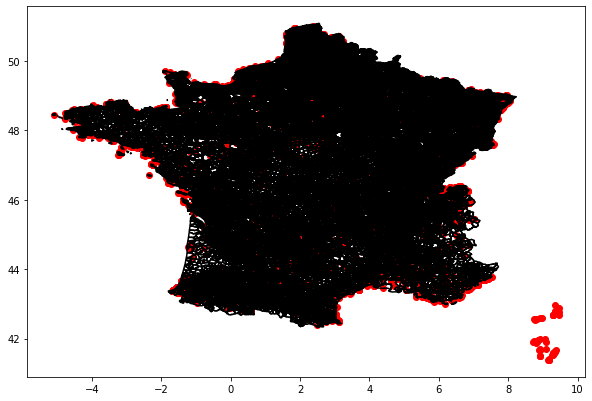

In [29]:
#drawing the restaurants position on france map
base=communes_borders.boundary.plot(facecolor="none", edgecolor="black",figsize=(10,10))
gpdDf.plot(ax=base,color = 'red', alpha = 1)

In [30]:
#saving the data
restaurantCommuneDf.to_csv("FrenchRestaurentCommune.csv")